In [1]:
import gym
import universe # register the universe environments
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import numpy as np
import cv2

In [5]:
env = gym.make('flashgames.CurveFever-v0')
env.configure(remotes=1)  # automatically creates a local docker container
observation_n = env.reset()

[2018-10-17 23:58:27,926] Making new env: flashgames.CurveFever-v0
[2018-10-17 23:58:27,930] Killing and removing container: id=f4e44741f4bd632687b38d02dbf6620a2bdc66d25361bb74d35e3e1b0bfe8428
[2018-10-17 23:58:28,489] Ports used: dict_keys([8888, 5900, 15900, 6006])
[2018-10-17 23:58:28,490] [0] Creating container: image=quay.io/openai/universe.flashgames:0.20.28. Run the same thing by hand as: docker run -p 5901:5900 -p 15901:15900 --privileged --cap-add SYS_ADMIN --ipc host quay.io/openai/universe.flashgames:0.20.28
[2018-10-17 23:58:29,038] Remote closed: address=172.17.0.1:5901
[2018-10-17 23:58:29,039] At least one sockets was closed by the remote. Sleeping 1s...
[2018-10-17 23:58:30,041] Remote closed: address=172.17.0.1:5901
[2018-10-17 23:58:30,045] Remote closed: address=172.17.0.1:15901
[2018-10-17 23:58:30,063] At least one sockets was closed by the remote. Sleeping 1s...
[2018-10-17 23:58:31,066] Using the golang VNC implementation
[2018-10-17 23:58:31,067] Using VNCSessio

## load observation

In [13]:
while True:
    action_n = [[('KeyEvent', 'ArrowUp', True)] for ob in observation_n]  # your agent here
    observation_n, reward_n, done_n, info = env.step(action_n)
    env.render()
    if(reward_n[0]!=0):
        print(reward_n)
    break

[2018-10-17 23:59:25,611] Throttle fell behind by 6.00s; lost 359.75 frames


## basic feature preprocessing

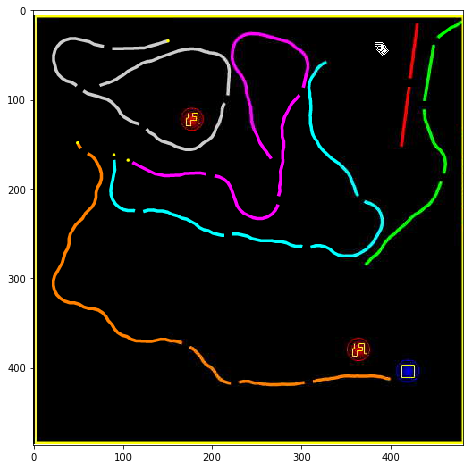

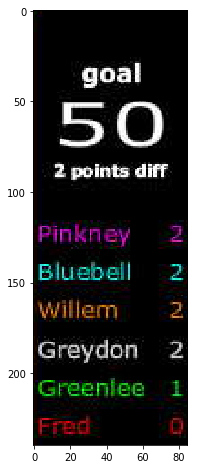

In [14]:
def segmend_screens(screen):
    game_screen = screen[78:565,53:535,:]
    score_screen = screen[90:330,535:620,:]
    return game_screen, score_screen

screen = observation_n[0]['vision']
game_screen, score_screen = segmend_screens(screen)

plt.figure(figsize = (8,8))
plt.imshow(game_screen)
plt.show()
plt.figure(figsize = (8,8))
plt.imshow(score_screen)
plt.show()

# extract snake

## find centers

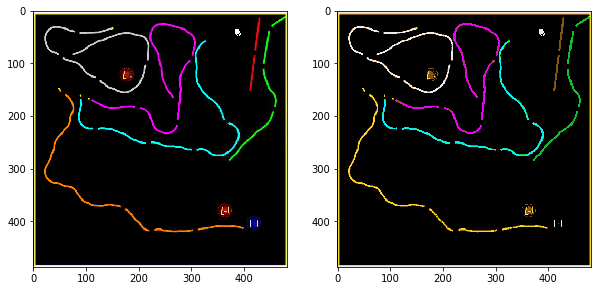

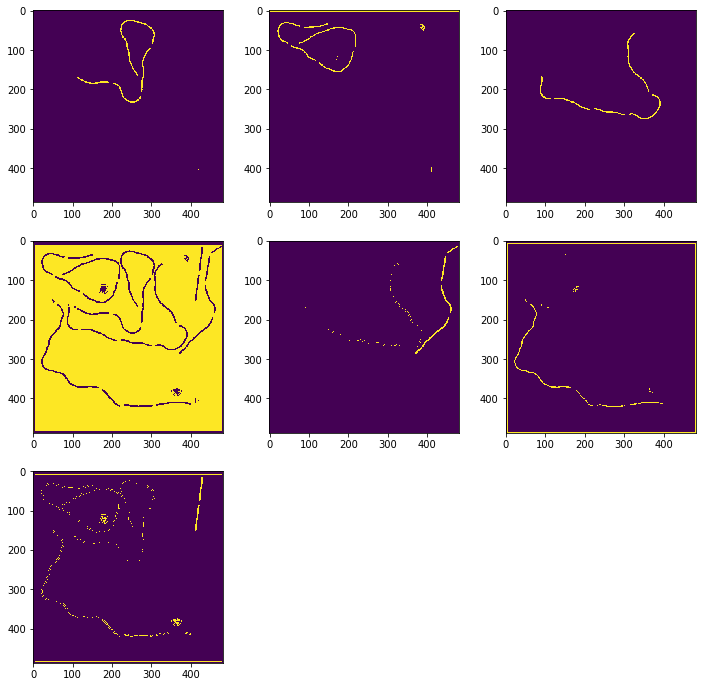

In [15]:
def find_centers(game_screen,n_centers = 7, render = True):
    #find kmeans centers
    Z = game_screen.reshape((-1,3))
    Z = np.float32(Z)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret,labels,center=cv2.kmeans(Z,n_centers,None,criteria,30,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[labels.flatten()].reshape((game_screen.shape))
    if(render):
        plt.figure(figsize=(10,5))
        ax = plt.subplot(1,2,1)
        ax.imshow(game_screen)

        ax = plt.subplot(1,2,2)
        ax.imshow(res)
        plt.show()

        plt.figure(figsize = (12,12))
        game_screen_segmented = labels.reshape(game_screen.shape[0:2])
        for n,id_label in enumerate(np.unique(labels)):
            ax = plt.subplot(3,3,n+1)
            ax.imshow(np.isin(game_screen_segmented,id_label))
    return center   
centers = find_centers(game_screen)

## infernce center

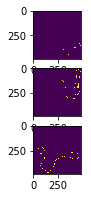

In [30]:

def get_snake(game_screen, centers, threshold = 50, image_path =''):
    fig = plt.figure(figsize = (10,3))
    for n, center in enumerate(centers):
        lower_bound = np.uint8(np.clip(center.astype(int) - threshold,0,255))
        upper_bound = np.uint8(np.clip(center.astype(int) + threshold,0,255))
        mask = cv2.inRange(game_screen, lower_bound, upper_bound)
        ax = plt.subplot(1,1,n+1)
        ax.imshow(mask)
#     fig.canvas.draw() 
#     img = np.array(fig.canvas.renderer._renderer)
    if(image_path):
        plt.savefig(image_path)
        plt.close()

snake_colors = np.array([[ 10, 225,  11],[  9, 236, 234],[194, 195, 194]])
get_snake(game_screen, snake_colors)


In [27]:
import os
import imageio

image_paths = []
basepath = '/app/plots/snakes'
if(not os.path.exists(basepath)):
    os.makedirs(basepath)
for i in range(20):
    action_n = [[('KeyEvent', 'ArrowUp', True)] for ob in observation_n]  # your agent here
    observation_n, reward_n, done_n, info = env.step(action_n)
    env.render()
    if(reward_n[0]!=0):
        print(reward_n)
    snake_colors = np.array([[ 10, 225,  11],[  9, 236, 234],[194, 195, 194],[236,   3, 235]])
    image_path = os.path.join(basepath,'{}.png'.format(i))
    image_paths.append(image_path)
    get_snake(game_screen, snake_colors,image_path = image_path) 

for filename in image_paths:
    images.append(imageio.imread(filename))
imageio.mimsave(os.path.join(basepath,'snake.gif'), images)


[2018-10-18 00:07:16,745] Throttle fell behind by 9.65s; lost 579.28 frames
[2018-10-18 00:07:18,359] Throttle fell behind by 1.06s; lost 63.83 frames
[2018-10-18 00:07:20,627] Throttle fell behind by 1.21s; lost 72.32 frames


(20, 720, 720, 4)